In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample
import matplotlib as mpl
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['axes.prop_cycle'] = mpl.rcParamsDefault['axes.prop_cycle']
%matplotlib widget

def load_data(dir, w, c, datetime):
    name = '%sS21s_w%d_%s_%s.npy' % (dir, w, c, datetime)
    darkname = '%s/S21_w%d_%s_%s_dark.npy' % (dir, w, c, datetime)
    freqsname = '%s/S21_w%d_%s_%s_freqs.npy' % (dir, w, c, datetime)
    # settings = '%s/S21_w%d_%s_%s_settings.txt' % (dir, w, c, datetime)
    s21s = np.load(name)
    s21dark = np.load(darkname)
    freqs = np.load(freqsname)
    return s21s, s21dark, freqs

def moving_average_filter(data, window_width):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_width:] = cumsum[window_width:] - cumsum[:-window_width]
    result = cumsum[window_width - 1:] / window_width
    result = np.concatenate((np.full(window_width - 1, result[0]), result))
    return result
            
def make_array():
    dir = 'S21s/19-10-23_w1_blue/'
    datetime = '12h16_19-10-2023'
    color = 'blue'
    w = 1
    freqsname = '%sS21_w%d_%s_%s_freqs.npy' % (dir, w, color, datetime)
    darkname = '%sS21_w%d_%s_%s_dark.npy' % (dir, w, color, datetime)
    freqs = np.load(freqsname)
    dark = np.load(darkname)
    data = np.zeros((45, 2, len(freqs)))
    for i in range(45):
        namex = '%sS21_x%dy0_w%d_%s_%s.npy' % (dir, i+1, w, color, datetime)
        namey = '%sS21_x0y%d_w%d_%s_%s.npy' % (dir, i+1, w, color, datetime)
        data[i, 0, :] = np.load(namex)
        data[i, 1, :] = np.load(namey)
    dataname = '%sS21s_w%d_%s_%s.npy' % (dir, w, color, datetime)
    np.save(dataname, data)

In [91]:
dir = 'S21s/19-10-23_w1_blue/'
s21s, dark, freqs = load_data(dir, 1, 'blue', '12h16_19-10-2023')
M_pxs = 20
N_pxs = 20
nr_scans = s21s.shape[0]
scan_stepsize = 75
px_size = 150
min_sep = px_size / 2
max_sep = px_size * np.sqrt(2)

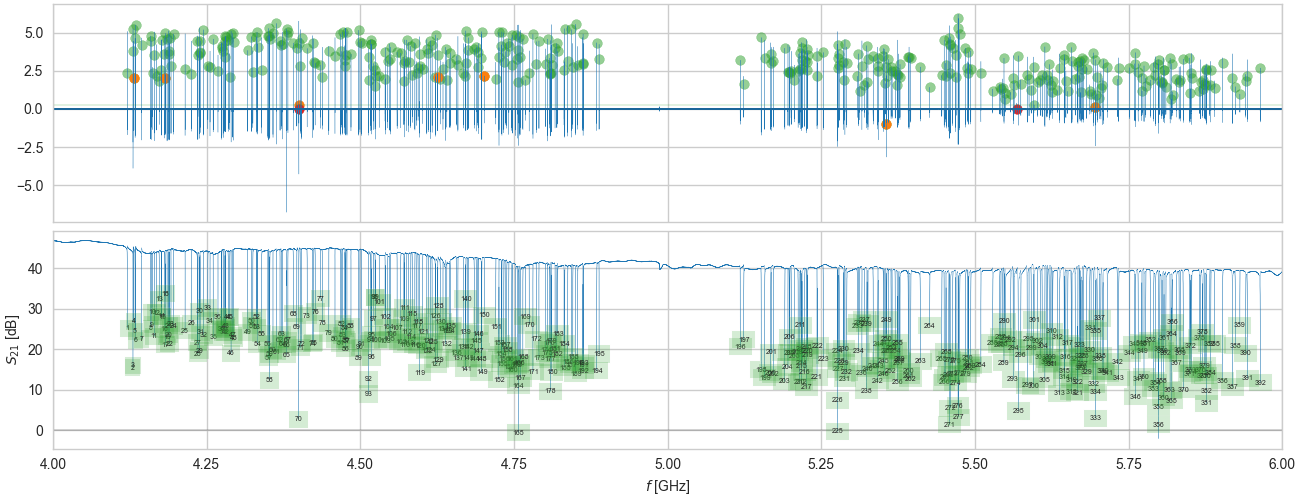

c:\Users\wilbertr\OneDrive\TU Delft\PhD\PythonProjects\spatial-mapping\.venv\lib\site-packages\ipympl\backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)


In [92]:
y = dark
width = 2
smoothed_y = moving_average_filter(y, width)
first_diff_y = np.diff(smoothed_y, 1)
smoothed_first_diff_y = moving_average_filter(first_diff_y, width)
sec_diff_y = np.diff(smoothed_first_diff_y, 1)
smoothed_sec_diff_y = moving_average_filter(sec_diff_y, width)

sel = 0.25
pks, props = find_peaks(smoothed_sec_diff_y, height=sel, prominence=sel)
real_pks = []
hs = []
for pk in pks:
    h = y[pk]  
    x = pk 
    new_x = x-1 
    new_h = y[new_x]
    while new_h < h:
        x = new_x
        h = new_h
        new_x -= 1
        new_h = y[new_x]
    real_pks.append(x)
    hs.append(h)
pks = np.array(real_pks)
# hs = np.array(hs)
hs = smoothed_sec_diff_y[real_pks]

stds = 2
pks_diff = pks[1:]-pks[:-1]
mean_pks_diff = np.mean(pks_diff)
std_mean_pks_diff = np.std(pks_diff)
close_pks = pks_diff < mean_pks_diff - stds*std_mean_pks_diff
hs_diff = hs[1:]-hs[:-1]
mean_hs_diff = np.mean(hs_diff)
std_mean_hs_diff = np.std(hs_diff)
low_hs = hs_diff < mean_hs_diff - stds*std_mean_hs_diff
sketchy_pks = pks[1:][low_hs + close_pks]

remove = [69, 295]
removed = pks[remove]
pks = np.delete(pks, remove)
hs = np.delete(pks, remove)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(13, 5), constrained_layout=True)
ax['a'].plot(freqs[1:-1], smoothed_sec_diff_y, lw=.2)
ax['a'].scatter(freqs[1:-1][pks], smoothed_sec_diff_y[pks], color='tab:green', alpha=0.5)
ax['a'].scatter(freqs[1:-1][sketchy_pks], smoothed_sec_diff_y[sketchy_pks], color='tab:orange')
ax['a'].scatter(freqs[1:-1][removed], smoothed_sec_diff_y[remove], color='tab:red')
ax['a'].axhline(0, 0, 1, color='k', lw=.2)
ax['a'].axhline(sel, 0, 1, color='tab:green', lw=.2)
for i, label in enumerate(range(len(pks))):
    ax['b'].text(freqs[pks[i]], y[pks[i]], str(label+1), ha='center', va='center', fontsize=5, bbox=dict(facecolor='tab:green', alpha=0.2))
ax['b'].plot(freqs, y, lw=.2)
# ax['b'].scatter(freqs[pks], y[pks], color='tab:green', alpha=0.5)
ax['b'].axhline(0, 0, 1, color='k', lw=.2)
ax['b'].set_xlabel('$f$ [GHz]')
ax['b'].set_ylabel('$S_{21}$ [dB]')
ax['b'].set_xlim((4, 6))
plt.show()


In [78]:
nr_pks = len(pks)
dark_heights = dark[pks]
height_diffs = np.zeros((nr_scans, nr_scans, nr_pks))
for i in range(nr_scans):
    scanx = s21s[i, 0, :]
    scany = s21s[i, 1, :]
    scanx_heights = scanx[pks]
    scany_heights = scany[pks]
    height_diffx = dark_heights - scanx_heights
    height_diffy = dark_heights - scany_heights
    height_diffs[i, 0, :] = height_diffx
    height_diffs[i, 1, :] = height_diffy

0

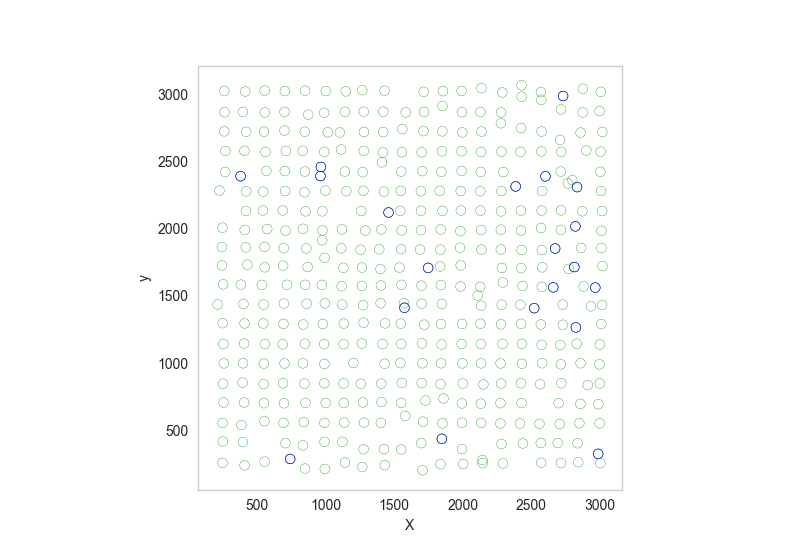

In [79]:
min = np.min(s21s)
max = np.max(s21s)
nr_pks = len(pks)
coords = np.zeros((nr_pks, 3)) 
coords[:, 0] = np.arange(nr_pks)+1

fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.grid(False)
height_diffs = resample(height_diffs, nr_scans*scan_stepsize, axis=0)
pos = np.arange(nr_scans*scan_stepsize)
dips = np.arange(nr_pks)
double_pks = np.zeros(nr_pks, dtype=bool)
for i in dips:
    scanx = height_diffs[:, 0, i]
    scany = height_diffs[:, 1, i]
    scanx = moving_average_filter(scanx, 50)
    scany = moving_average_filter(scany, 50)
    meanx = np.mean(scanx)
    stdx = np.std(scanx)
    meany = np.mean(scany)
    stdy = np.std(scany)
    scanx -= meanx - stdx
    scany -= meany - stdy

    scanxpks, props = find_peaks(-scanx, height=0, prominence = 2)
    scanypks, props = find_peaks(-scanx, height=0, prominence = 2)
    
    peakx = scanx < 0
    peaky = scany < 0

    pkx = np.amin(scanx)
    pky = np.amin(scany)
    
    if (len(scanxpks)==1) and (len(scanypks)==1):
        idxy = np.mean(pos[peaky])
        idxx = np.mean(pos[peakx])
        coords[i, 1:] = idxx, idxy
    else:   
        idxx = np.argmin(scanx)
        idxy = np.argmin(scany)
        double_pks[i] = True
        coords[i, 1:] = idxx, idxy
        ax.scatter(idxx, idxy, facecolor='None', edgecolor='b')
        # fig, axes = plt.subplot_mosaic('ab', figsize=(10, 3))
        # axes['a'].plot(pos, scanx, lw=.5)
        # axes['a'].plot(pos, peakx, lw=.5)
        # axes['a'].set_title('%s, X' % (i))
        # axes['a'].scatter(idxx, pkx)
        # axes['b'].plot(pos, scany, lw=.5)
        # axes['b'].plot(pos, peaky, lw=.5)
        # axes['b'].set_title('%s, Y' % (i))
        # axes['b'].scatter(idxy, pky)
ax.scatter(coords[:, 1], coords[:, 2], facecolor='None', edgecolor='tab:green')
ax.scatter(coords[double_pks, 1], coords[double_pks, 2], facecolor='None', edgecolor='b')
ax.set_xlabel('X')
ax.set_ylabel('y')
len(np.argwhere(coords==0))


In [80]:
dists = np.zeros((nr_pks, nr_pks))
for i in range(nr_pks):
        for j in range(nr_pks):
            dists[i, j] = np.linalg.norm(coords[i, 1:] - coords[j, 1:])
dists.shape

(392, 392)

In [81]:
min_sep = 100
too_close = np.zeros(nr_pks, dtype=bool)
too_close[np.hstack(np.where((dists < min_sep) & (dists != 0)))] = True
print('too close:', np.sum(too_close))

too close: 46


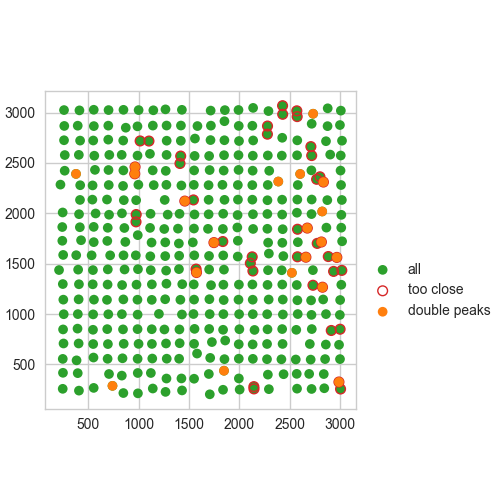

In [116]:
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.set_aspect(1)
ax.scatter(coords[:, 1], coords[:, 2],  facecolor='tab:green', edgecolor='None', label='all')
ax.scatter(coords[too_close, 1], coords[too_close, 2],  facecolor='None', edgecolor='tab:red', label='too close', linewidth=1)
# ax.scatter(coords[too_far, 1], coords[too_far, 2], marker='.', marker='x', facecolor='g')
ax.scatter(coords[double_pks, 1], coords[double_pks, 2], facecolor='tab:orange', edgecolor='None', label='double peaks')
ax.legend(loc='best', bbox_to_anchor=(1, .5))

In [111]:
new_coords = np.delete(coords, too_close+double_pks, axis=0)
nr_sel_pks = len(new_coords)

x_min = np.amin(new_coords[:, 1])
y_min = np.amin(new_coords[:, 2])
x_max = np.amax(new_coords[:, 1])
y_max = np.amax(new_coords[:, 2])
new_coords[:, 1] -= x_min - px_size / 4
new_coords[:, 2] -= y_min - px_size / 4



Too little KIDs found at 1 1075.0 [295.]
Too little KIDs found at 2 1662.5 [243.]


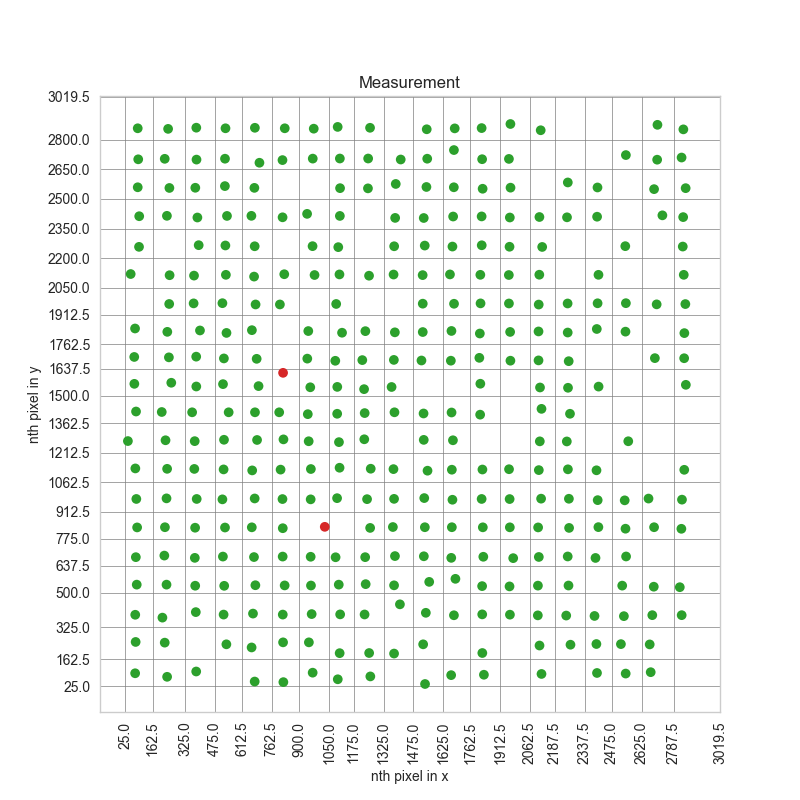

In [113]:
def get_edges(array, axis): 
    dx = 25
    x = 25
    x_left = 0
    diff = 25
    x_edges = [0]
    min_sep = 50
    min_nr_kids = 5
    max_nr_kids = 20
    nr_kids_init = 0
    cum_nr_kids = 0
    lonely_kids = np.zeros(array.shape[0], dtype=bool)
    pxs = np.empty((array.shape[0]))
    pxs[:] = np.nan
    # px = 1
    while x < x_max:
        prev_edge = x_edges[-1]
        cum_mask = (array[:, axis] < x_left) & (array[:, axis] >= prev_edge)
        cum_nr_kids = np.sum(cum_mask) 
        mask = (array[:, axis] < x) & (array[:, axis] >= x_left)
        nr_kids = np.sum(mask)
        kids = array[mask]
        if nr_kids > 0:
            if (diff >= min_sep):
                edge = x - diff / 2
                if (cum_nr_kids <= min_nr_kids) & (cum_nr_kids) > 0:
                    print('Too little KIDs found at', axis, edge, array[cum_mask][:, 0])
                    lonely_kids += cum_mask
                elif (cum_nr_kids > max_nr_kids):
                    print(print('Too many KIDs found at', axis, edge, cum_nr_kids))
                x_edges.append(edge)
                # px_mask = (array[:, axis] < edge) & (array[:, axis] >= prev_edge)
                # pxs[px_mask] = px
                # px += 1
                cum_nr_kids = nr_kids_init
            diff = dx
        else:
            diff += dx
        x_left = x
        x = x_left + dx
    x_edges.append(x_max)
    return np.array(x_edges[1:]), lonely_kids, pxs


x_edges, x_losers, _ = get_edges(new_coords, 1)
y_edges, y_losers, _ = get_edges(new_coords, 2)
losers = x_losers+y_losers
newnew_coords = np.delete(new_coords, losers, axis=0)
x_edges, _, pxx = get_edges(newnew_coords, 1)
y_edges, _, pxy = get_edges(newnew_coords, 2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(newnew_coords[:, 1], newnew_coords[:, 2], facecolor='tab:green', edgecolor='None')
ax.scatter(new_coords[losers, 1], new_coords[losers, 2], facecolor='tab:red', edgecolor='None')

xticks = x_edges
yticks = y_edges
ax.set_xticks(xticks[0::1])
ax.set_yticks(yticks[0::1])
# Labels for major ticks
ax.set_xticklabels(xticks[0::1], rotation='vertical')
ax.set_yticklabels(yticks[0::1], rotation='horizontal')
# labels
ax.set_xlabel('nth pixel in x')
ax.set_ylabel('nth pixel in y')
ax.set_title("Measurement")
# grid
ax.grid(True, which='major', color='tab:gray', linestyle='-', linewidth=0.5)
# ax.grid(False, which='major')

In [117]:
def edges2px(array, edges, axis):
    pxs = np.empty((array.shape[0]), dtype=int)
    nr_edges = len(edges)
    for i in range(nr_edges-1):
        left = edges[i]
        right = edges[i+1]
        mask = (array[:, axis] < right) & (array[:, axis] >= left)
        pxs[mask] = i+1
    return pxs

pxx = edges2px(newnew_coords, x_edges, 1)
pxy = edges2px(newnew_coords, y_edges, 2)
pxs = np.stack((pxx, pxy), axis=1)
pxs
kids = np.empty((M_pxs, N_pxs))
kids[:] = np.nan
for i in range(newnew_coords.shape[0]):
    kids[pxs[i, 0]-1, pxs[i, 1]-1] = newnew_coords[i, 0]
kids = np.flip(kids, axis=1)
kids = np.flip(kids, axis=0)

In [118]:
kid_id_board = np.load('./LT295_400pxl_design/KID_id_board_400.npy')
mask = (kids == kid_id_board)
nr_tot = (M_pxs*N_pxs)
nr_detected = nr_pks
nr_notswapped = np.sum(mask)
nr_identified = np.sum(~np.isnan(kids))
nr_swapped = nr_identified - nr_notswapped
same = np.argwhere(mask)
f0s_design = np.load('./LT295_400pxl_design/resonance_freq_SONNET.npy')
f0s = freqs[pks]*1e9
diff = np.empty(kids.shape)
diff[:] = np.nan
df = np.empty(kids.shape)
df[:] = np.nan
for i in range(M_pxs):
    for j in range(N_pxs):
        design_idx = kid_id_board[i, j] - 1
        design_f0 = f0s_design[design_idx]
        idx = kids[i, j] - 1
        if ~np.isnan(idx):
            idx = int(idx)
            f0 = f0s[idx]
            diff[i, j] = (f0 - design_f0) / design_f0
            df[i, j] = (f0 - design_f0)
std_diff = np.std(diff[~np.isnan(diff)])

# detected: 392/400
# identified: 336/392
# swapped: 308/336 


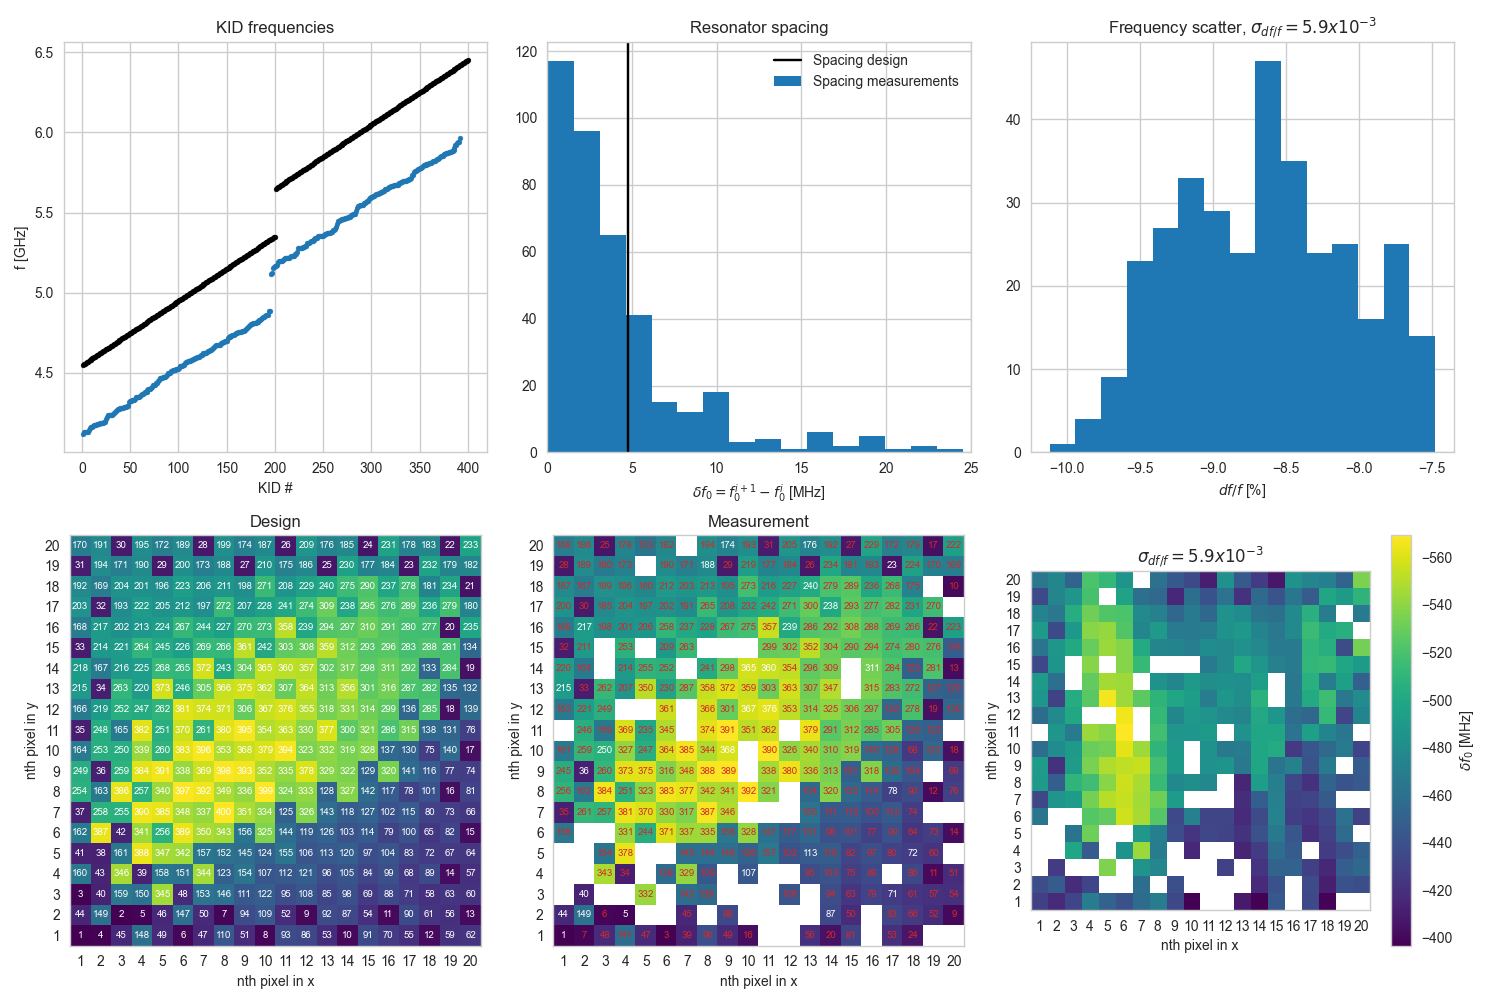

In [120]:
fig, ax = plt.subplot_mosaic('edf;bac', figsize=(15, 10))
ax['a'].imshow(kids, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kids[i, j]
        if ~np.isnan(idx):
            if mask[i, j]:
                color = 'w'
            else:
                color = 'tab:red'
            text = ax['a'].text(j, i, '%d' % idx, ha="center", va="center", color=color, fontsize='x-small') 
# Major ticks
ax['a'].set_xticks(np.arange(0, M_pxs, 1));
ax['a'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['a'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['a'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['a'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['a'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['a'].set_xlabel('nth pixel in x')
ax['a'].set_ylabel('nth pixel in y')
ax['a'].set_title("Measurement")
# grid
ax['a'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['a'].grid(False, which='major')

############################
im = ax['b'].imshow(kid_id_board, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kid_id_board[i, j]
        if ~np.isnan(idx):
            text = ax['b'].text(j, i, '%d' % idx, ha="center", va="center", color="w", fontsize='x-small')   
# Major ticks
ax['b'].set_xticks(np.arange(0, M_pxs, 1));
ax['b'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['b'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['b'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['b'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['b'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['b'].set_xlabel('nth pixel in x')
ax['b'].set_ylabel('nth pixel in y')
ax['b'].set_title("Design")
# grid
ax['b'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['b'].grid(False, which='major')

###################################
im = ax['c'].imshow(df*1e-6, origin='lower', cmap='viridis_r')
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['c'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['c'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['c'].set_xlabel('nth pixel in x')
ax['c'].set_ylabel('nth pixel in y')
ax['c'].set_title("$\sigma_{df/f}=%.1f x 10^{-3}$" % (std_diff*1e3))
# grid
ax['c'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['c'].grid(False, which='major')
cbar = fig.colorbar(im, ax=ax['c'])
cbar.ax.invert_yaxis()
cbar.ax.set_ylabel('$\delta f_0$ [MHz]')
# final


##################################
average_spacing_design = np.mean(f0s_design[1:]- f0s_design[:-1])*1e-6
_ = ax['d'].axvline(average_spacing_design, color='k', label='Spacing design')
_ = ax['d'].hist((f0s[1:]- f0s[:-1])*1e-6, bins=150, label='Spacing measurements')
ax['d'].set_title('Resonator spacing')
ax['d'].set_xlim(0, 25)
ax['d'].set_xlabel('$\delta f_0=f_0^{i+1}-f_0^{i}$ [MHz]')
ax['d'].legend()

##################################
ax['e'].scatter(np.arange(len(f0s))+1, f0s*1e-9, marker='.', label='measurement')
ax['e'].scatter(np.arange(nr_tot)+1, f0s_design*1e-9, marker='.', label='design', c='k')
ax['e'].set_ylabel('f [GHz]')
ax['e'].set_xlabel('KID #')
ax['e'].set_title('KID frequencies')
ax['e'].legend()

ax['f'].hist((diff.flatten()*100), bins=15)
# ax['f'].set_xlim((-11, -6))
ax['f'].set_xlabel('$df/f$ [%]')
ax['f'].set_title("Frequency scatter, $\sigma_{df/f}=%.1f x 10^{-3}$" % (std_diff*1e3))
ax['e'].legend('')
print('# detected: %d/%d\n# identified: %d/%d\n# swapped: %d/%d ' % (nr_detected, nr_tot, nr_identified, nr_detected, nr_swapped, nr_identified))
fig.tight_layout()